# Predicting House Prices on Kaggle

Implement two utility functions

In [1]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder, return the local filepath"""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

Read in and process the data
using `pandas`

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


Take a look at the first four and last two features
as well as the label (SalePrice)

In [5]:
print(data.raw_train.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


Replacing all missing values
by the corresponding feature's mean.
*standardize* the data by
rescaling features to zero mean and unit variance
Next we deal with discrete values.
We replace them by a one-hot encoding

In [7]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    features[numeric_features] = features[numeric_features].fillna(0)
    features = pd.get_dummies(features, dummy_na=True)
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

data.preprocess()
data.train.shape

(1460, 332)

In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    tensors = (get_tensor(data.drop(columns=[label])),
               torch.log(get_tensor(data[label])).reshape((-1, 1)))
    return self.get_tensorloader(tensors, train)

We tend to care more about
the relative error $\frac{y - \hat{y}}{y}$
One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.
$K$-fold cross-validation

In [9]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

The training and verification error averages are returned

In [10]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(data.train.shape[1]-1, lr)
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log rmse = {sum(val_loss)/len(val_loss)}')
    return models

Model Selection

average validation log rmse = 0.18164687901735305


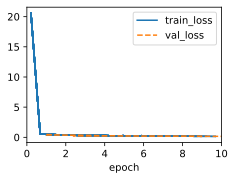

In [11]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Submitting Predictions on Kaggle

In [13]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32)) for model in models]
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)

submission = pd.DataFrame({'Id':data.raw_val.Id, 'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)